In [1]:
import maboss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tools import to_bits, to_istates, change_inputs

# Analysis of the Cell fate Boolean model

In this Jupyter notebook, we'll look at the properties of the model by Calzone et al and study the effect of the TNF treatment on the possible cell fates. 

### Performing the default simulation

First, we need to locate the BND and CFG files of the model, which are located in the config/simple_tnf folder and we load this model files to create out simulation object

In [2]:
# Set up the required files
path = "../config/simple_tnf/boolean_network/"
bnd_file = os.path.join(path, "cellfate.bnd")
cfg_WT = os.path.join(path, "cellfate.cfg")
b_sim = maboss.load(bnd_file, cfg_WT)

Then we create our default settings : the max time (here a bit more than 4 days), the step size of the simulation (1h), and the number of individual simulations (100k). 
We also choose which nodes will appear in the result of the simulation. Here we only want to see if cells commit to one of the three cell fates : Survival, Apoptosis, or Necrosis (NonACD).

We update our simulation to follow these settings :

In [3]:
param = {'max_time': 105, 'time_tick': 1, 'sample_count': 100000}
outputs = ['NonACD', 'Apoptosis', 'Survival']
b_sim.param.update(param)
b_sim.network.set_output(outputs)

### No TNF treatment

The first condition we want to simulate is the absence of TNF treatment. For this, we modify our simulation to set the probability of TNF node off to 100% (1).

In [4]:
b_sim.network.set_istate('TNF', [1, 0])

We then lauch our simulation, and plot the distribution of states at the end of the simulation

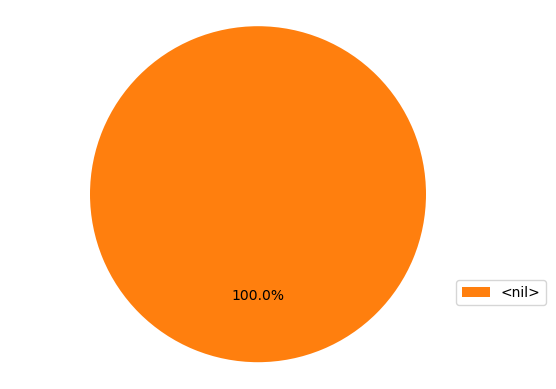

In [5]:
b_res = b_sim.run()
b_res.plot_piechart()

As we can see, in the absence of TNF treatment, cells do not commit to any of the cell fates.

### Same one with TNF treatment

This time we want to see what happens if we simulate a TNF treatment. First, we create a new simulation object, based on a copy of the previous one. In this new object, we set the probability of the TNF node to be active to 100% (1). We then launch the simulation, and plot the distribution of states at the end of the simulation :

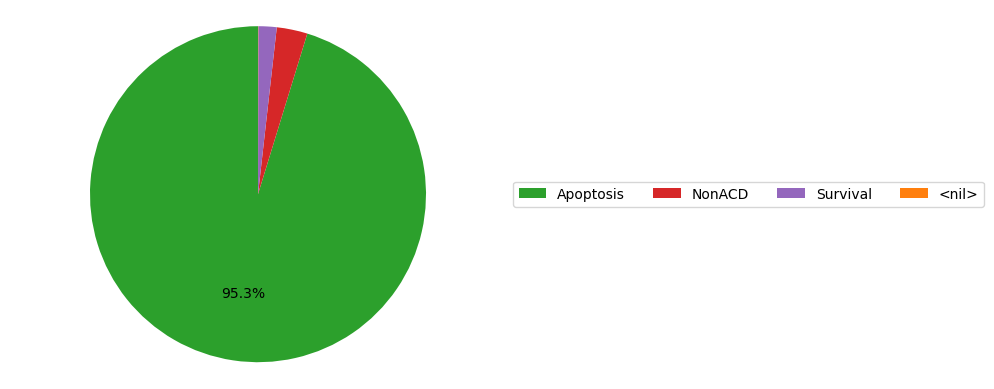

In [6]:
b_sim_tnf = b_sim.copy()
b_sim_tnf.network.set_istate('TNF', [0, 1])
b_res_tnf = b_sim_tnf.run()
b_res_tnf.plot_piechart(prob_cutoff=0.0001)
plt.legend(["Apoptosis", "NonACD", "Survival", "<nil>"], ncols=4, loc='center left', bbox_to_anchor=(1, 0.5))

We can see that this time, the vast majority of the cells commit to one of the cell fates : 
- ~95% commit to Apoptosis
- ~3% commit to Necrosis
- ~2% commit to Survival

A very small proportion of the cells haven't yet commited to a cell fate.

We can then plot the trajectory of the simulation : 

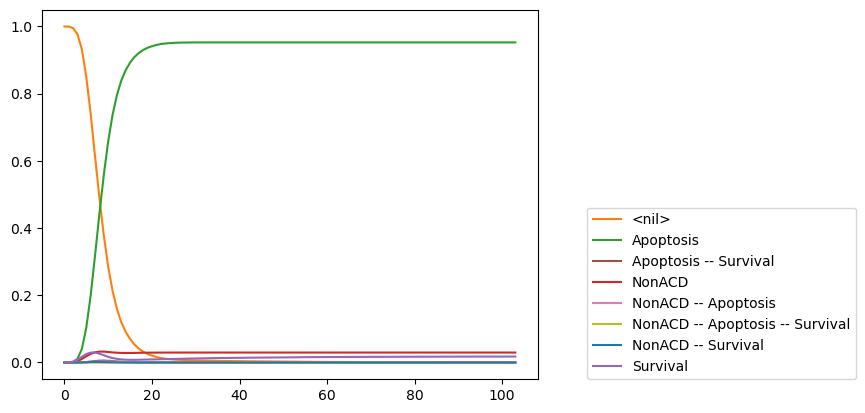

In [7]:
b_res_tnf.plot_trajectory(prob_cutoff=0)

Here we see the transient behaviour of the TNF effect : cells start uncommited, and progressively commit to one of the phenotypes. We can see that some cells initially activate Survival, and end up inactivating it to choose another cell fate. 

We can also see (although barely) a transient behaviour, mixed cell fates : some cells with activate multiple cell fates at the same time. 

### Focusing on mixed cell fates

Let's look at this in more details, by only plotting these states. To do this, we use the representation of the results as a Panda dataframe, filter to get only these mixed states, and plot them : 

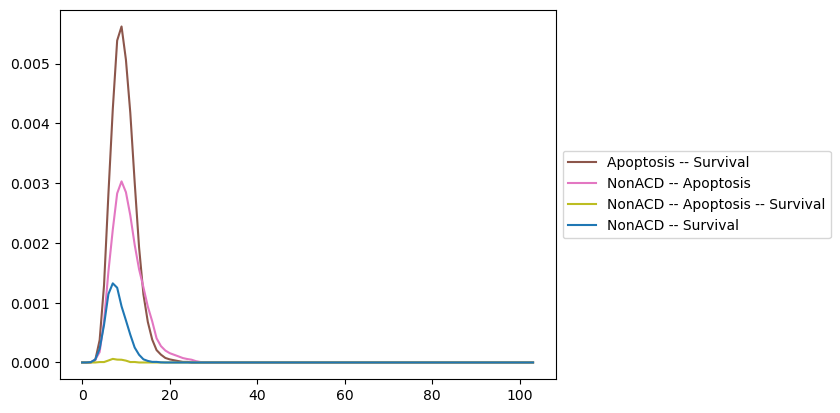

In [8]:
b_res_tnf.get_states_probtraj().loc[:, ["Apoptosis -- Survival", "NonACD -- Apoptosis", "NonACD -- Apoptosis -- Survival", "NonACD -- Survival"]].plot(color=['C5', 'C6', 'C8', 'C0',])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We can see that we get a peak of these mixed phenotypes during the first 24 hours, after which they mostly disappear. 

### Pulses of TNF treatments

We will now focus in a new type of treatment : pulses of TNF. This type of simulation is a bit more complex, as we need to chain multiple simulations, meaning that we will use the end state of one simulation as the initial state of a following one. 

Since MaBoSS only saves the simulations results for a specific list of output nodes, we want to also do simulations with all nodes marked as output, otherwise we would loose information on the state of many nodes. For this we need two simulations : 
- One with all nodes as outputs, to be able to completely specify the next simulation's initial condition
- One with only the output we want, to be able to generate the figure (the *_fig simulations)

We first define the duration of the treatment (24h), and the duration of the interval between treatments (24h). 

In [9]:
dur_tnf = 24
dur_no_tnf = 24

We also build a list of all the nodes of the model that we will use for this part, to make sure we always have the same order

In [10]:
nodes = list(b_sim_tnf.network.keys())

#### First, with TNF

We copy the previous simulation with TNF treatment, and update it with the duration of the TNF treatment. We start with the full simulation, the one with all the nodes as output : 

In [11]:
sim_1_full = b_sim_tnf.copy()
sim_1_full.update_parameters(max_time=dur_tnf)
sim_1_full.network.set_output(nodes)
res_1_full = sim_1_full.run()

and we continue with the simple simulation, this time with only the cell fate nodes as output. 

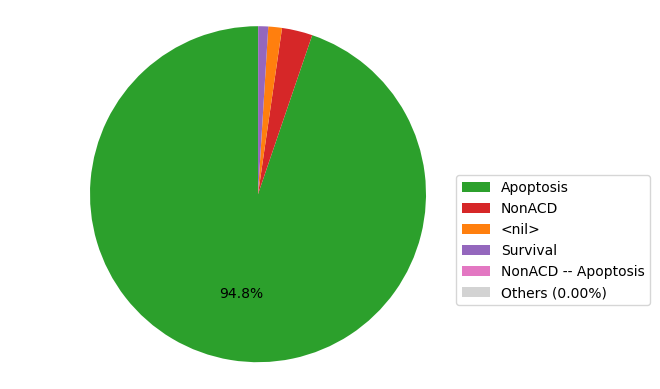

In [12]:
sim_1_simple = sim_1_full.copy()
sim_1_simple.network.set_output(outputs)
res_1_simple = sim_1_simple.run()
res_1_simple.plot_piechart(prob_cutoff=0.0001)

We can see the same behaviour we saw earlier : Most cells commited to apoptosis, a few cells to necrosis, and even fewer to survival

#### Second, no TNF

First we have to generate our new initial states based on the last time point of the previous simulation, in which we only change the initial value of the TNF node to deactivate it:

In [13]:
new_istates = change_inputs(nodes, to_istates(res_1_full.get_states_probtraj(), nodes), {"TNF": 0})

We then build our second full simulation, and set its initial states to the one we just generated

In [14]:
sim_2_full = sim_1_full.copy()
sim_2_full.update_parameters(max_time=dur_no_tnf)
sim_2_full.network.set_istate(nodes, new_istates)
res_2_full = sim_2_full.run()

We then run our simple simulation, only looking at the cell fates nodes

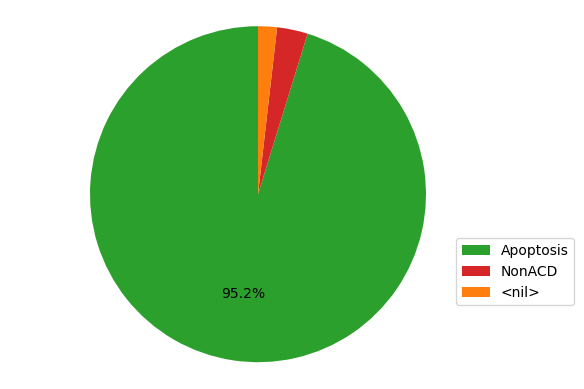

In [15]:
sim_2_simple = sim_2_full.copy()
sim_2_simple.network.set_output(outputs)
res_2_simple = sim_2_simple.run()
res_2_simple.plot_piechart(prob_cutoff=0.0001)

Here after this new simulation, this time without TNF active, we see that the cells which had previously commited to apoptosis and necrosis don't change. However, the cells which had previously commited to survival go back to being uncommited to a cell fate.

#### Third, with TNF

Again, we have to generate our new initial states based on the last time point of the previous simulation, in which we only change the initial value of the TNF node to this time re-activate it:

In [16]:
new_istates = change_inputs(nodes, to_istates(res_2_full.get_states_probtraj(), nodes), {"TNF": 1})

We then create and run our full simulation, based on these new initial states:

In [17]:
sim_3_full = sim_2_full.copy()
sim_3_full.update_parameters(max_time=dur_tnf)
sim_3_full.network.set_istate(nodes, new_istates)
res_3_full = sim_3_full.run()

Warning, node FASL was previously bound to othernodes


And we run our simple simulation:

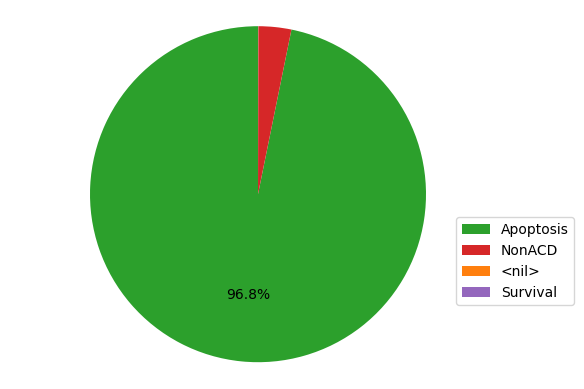

In [18]:
sim_3_simple = sim_3_full.copy()
sim_3_simple.network.set_output(outputs)
res_3_simple = sim_3_simple.run()
res_3_simple.plot_piechart(prob_cutoff=0.0001)

Here we observed that after this second round of TNF treatment, the previously uncommited cells dit commit to one of the cell fates (again, mostly to apoptosis). We still have a very small amount of cells which committed to survival. 

#### Fourth, no TNF

Again, we have to generate our new initial states based on the last time point of the previous simulation, in which we only change the initial value of the TNF node to this time deactivate it:

In [19]:
new_istates = change_inputs(nodes, to_istates(res_3_full.get_states_probtraj(), nodes), {"TNF": 0})

We then create and run our full simulation, based on these new initial states:

In [20]:
sim_4_full = sim_3_full.copy()
sim_4_full.update_parameters(max_time=dur_no_tnf)
sim_4_full.network.set_istate(nodes, new_istates)
res_4_full = sim_4_full.run()

Warning, node FASL was previously bound to othernodes


And we run our simple simulation:

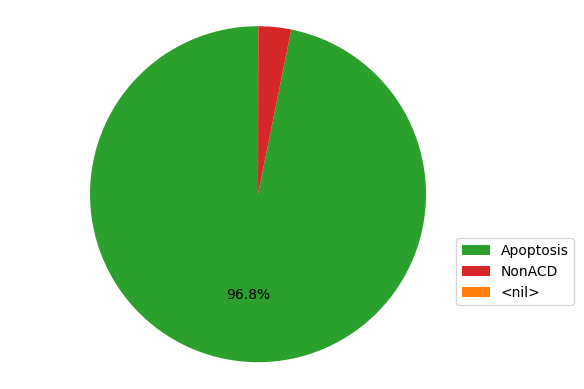

In [21]:
sim_4_simple = sim_4_full.copy()
sim_4_simple.network.set_output(outputs)
res_4_simple = sim_4_simple.run()
res_4_simple.plot_piechart(prob_cutoff=0.0001)

As previously, the cells commited to apoptosis or necrosis don't change, but the cells which commited to survival go back to being uncommited. 

#### Fifth, with TNF

Again, we have to generate our new initial states based on the last time point of the previous simulation, in which we only change the initial value of the TNF node to this time re-activate it:

In [22]:
new_istates = change_inputs(nodes, to_istates(res_4_full.get_states_probtraj(), nodes), {"TNF": 1})

We then create and run our full simulation, based on these new initial states:

In [23]:
sim_5_full = sim_4_full.copy()
sim_5_full.update_parameters(max_time=dur_tnf)
sim_5_full.network.set_istate(nodes, new_istates)
res_5_full = sim_5_full.run()

Warning, node FASL was previously bound to othernodes


And we run our simple simulation:

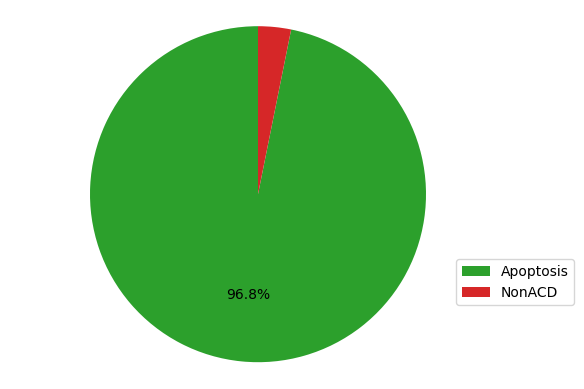

In [24]:
sim_5_simple = sim_5_full.copy()
sim_5_simple.network.set_output(outputs)
res_5_simple = sim_5_simple.run()
res_5_simple.plot_piechart(prob_cutoff=0.0001)

Here we see that after this third round of treatment, there is no more (detectable) population of cells commited to survival

#### Finally, we merge the trajectories of the five simulations

To be able to look at the consolidated trajectory, we extract the trajectory of the previous 5 simulations:

In [25]:
table_1 = res_1_simple.get_states_probtraj()
table_2 = res_2_simple.get_states_probtraj()
table_3 = res_3_simple.get_states_probtraj()
table_4 = res_4_simple.get_states_probtraj()
table_5 = res_5_simple.get_states_probtraj()

We need to fix the index since otherwise all the five simulations start at 0

In [26]:
table_2.index = np.array([value + dur_tnf - 1 for value in table_2.index.values])
table_3.index = np.array([value + dur_tnf + dur_no_tnf - 2 for value in table_3.index.values])
table_4.index = np.array([value + dur_tnf + dur_no_tnf + dur_tnf - 3  for value in table_4.index.values])
table_5.index = np.array([value + dur_tnf + dur_no_tnf + dur_tnf + dur_no_tnf - 4 for value in table_5.index.values])

And finally we generate a figure with the consolidated trajectory, with the treatment periods in grey:

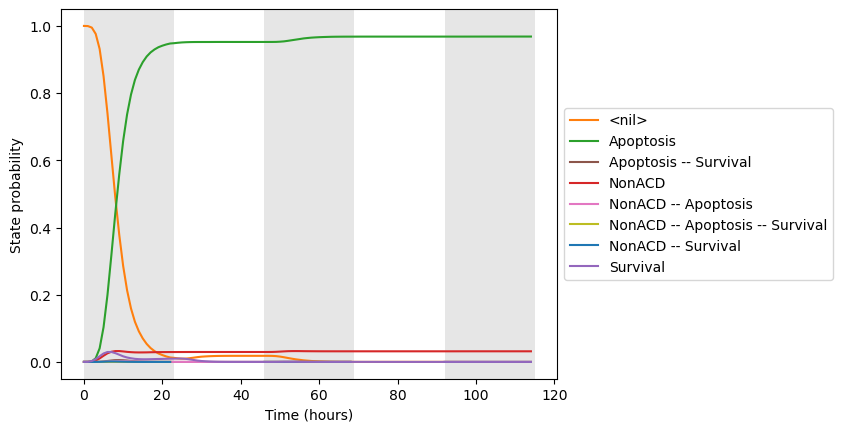

In [27]:
fig = plt.figure()
fig.subplots(1)
pd.concat([table_1, table_2, table_3, table_4, table_5]).plot(ax=fig.axes[0],color=['C1', 'C2', 'C5', 'C3', 'C6', 'C8', 'C0', 'C4'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (hours)')
plt.ylabel('State probability')
fig.axes[0].axvspan(0., dur_tnf-1, facecolor='0.9')
fig.axes[0].axvspan(dur_tnf+dur_no_tnf-2, dur_tnf+dur_no_tnf+dur_tnf-3, facecolor='0.9')
fig.axes[0].axvspan(dur_tnf+dur_no_tnf+dur_tnf+dur_no_tnf-4, dur_tnf+dur_no_tnf+dur_tnf+dur_no_tnf+dur_tnf-5, facecolor='0.9')

To conclude this last part, with pulsative treatments we can observe a behaviour which couldn't be seen with a permanent treatment : the population of cells surviving the TNF treatment (resistant cells) can be destroyed by the alternance of treatment and pauses. 